## Домашнє завдання: Незбалансована багатокласова класифікація

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

## Завдання 1

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
file_name = '/content/drive/MyDrive/ML/data/customer_segmentation_train.csv'

In [ ]:
data = pd.read_csv(file_name)

In [ ]:
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [ ]:
for col in data.select_dtypes(include=["object"]):
    print(data[col].apply(type).value_counts())

Gender
<class 'str'>    8068
Name: count, dtype: int64
Ever_Married
<class 'str'>      7928
<class 'float'>     140
Name: count, dtype: int64
Graduated
<class 'str'>      7990
<class 'float'>      78
Name: count, dtype: int64
Profession
<class 'str'>      7944
<class 'float'>     124
Name: count, dtype: int64
Spending_Score
<class 'str'>    8068
Name: count, dtype: int64
Var_1
<class 'str'>      7992
<class 'float'>      76
Name: count, dtype: int64
Segmentation
<class 'str'>    8068
Name: count, dtype: int64


Заповнення пустих значень:

Для заповнення пустих значень використаємо стратегію, де для категоріаьних колонок заповнимо всі пусті значення найбільш поширеним значенням. Для числових колонок - заповнимо їх медіаною.

In [ ]:
data['Ever_Married'] = data['Ever_Married'].fillna(data['Ever_Married'].mode()[0])
data['Graduated'] = data['Graduated'].fillna(data['Graduated'].mode()[0])
data['Profession'] = data['Profession'].fillna(data['Profession'].mode()[0])
data['Var_1'] = data['Var_1'].fillna(data['Var_1'].mode()[0])

data['Work_Experience'] = data['Work_Experience'].fillna(data['Work_Experience'].median())
data['Family_Size'] = data['Family_Size'].fillna(data['Family_Size'].median())

print(data.isnull().sum())

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


In [ ]:
input = data.drop(columns=['Segmentation'])
target = data['Segmentation']

In [ ]:
categorical_cols = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1" ]
numeric_cols = ["Age", "Work_Experience", "Family_Size"]

Кількість унікальних значень в кожній з колонок:

In [ ]:
for col in data.select_dtypes(include=["object"]):
    print(f"{col}: {data[col].nunique()}")

Gender: 2
Ever_Married: 2
Graduated: 2
Profession: 9
Spending_Score: 3
Var_1: 7
Segmentation: 4


Кодування категоріальних ознак:

Категоріальні ознаки закодуємо за допомогою OneHotEncoder.

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(input[categorical_cols])

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
input[encoded_cols] = encoder.transform(input[categorical_cols])

In [ ]:
input = input[numeric_cols + encoded_cols]
display(input.head())

,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38,1.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,67,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,67,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,40,1.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       8068 non-null   int64  
 1   Work_Experience           8068 non-null   float64
 2   Family_Size               8068 non-null   float64
 3   Gender_Female             8068 non-null   float64
 4   Gender_Male               8068 non-null   float64
 5   Ever_Married_No           8068 non-null   float64
 6   Ever_Married_Yes          8068 non-null   float64
 7   Graduated_No              8068 non-null   float64
 8   Graduated_Yes             8068 non-null   float64
 9   Profession_Artist         8068 non-null   float64
 10  Profession_Doctor         8068 non-null   float64
 11  Profession_Engineer       8068 non-null   float64
 12  Profession_Entertainment  8068 non-null   float64
 13  Profession_Executive      8068 non-null   float64
 14  Professi

Розбиття вибірки:

Для зручності, та заважаючи на невеликий обсяг даних було прийнято рішення розбивати дані на тренувальну на валідаційну вибірку вже після препроцесингу.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input, target, test_size=0.2, random_state=42, stratify=target)

## Завання 2

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

#### SMOTE

PCA

Щоб візуалізувати реузльтати ресамплінгу вирішила полнизити розмірність за допомогою PCA, та відобразити на графіку.

In [ ]:
unique_classes = target.unique()
colors = plt.cm.tab10(range(len(unique_classes)))
class_color_map = {cls: color for cls, color in zip(unique_classes, colors)}

def plot_data_with_pca(X, y, title):
    X_pca = PCA(n_components=2).fit(X).transform(X)
    fig, ax = plt.subplots(figsize=(15, 4))
    for cls in sorted(set(y)):
        plt.scatter(X_pca[y == cls, 0], X_pca[y == cls, 1],
                    label=f'Class {cls}', alpha=0.6, edgecolor='black', s=30)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()
    print(y.value_counts())

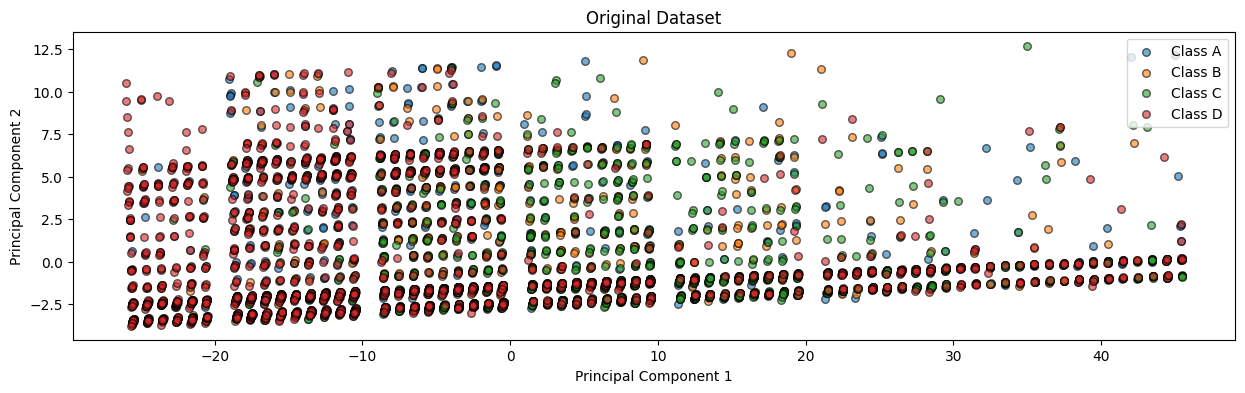

Segmentation
D    1814
A    1578
C    1576
B    1486
Name: count, dtype: int64


In [ ]:
plot_data_with_pca(X_train, y_train, title='Original Dataset')

SMOTE

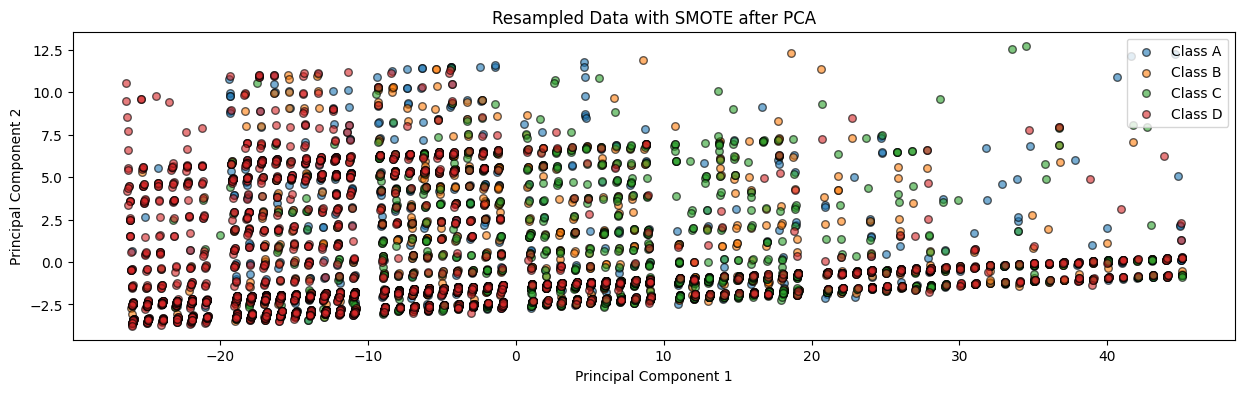

Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train[numeric_cols], y_train)
plot_data_with_pca(X_train_smote, y_train_smote, title="Resampled Data with SMOTE after PCA")

In [ ]:
X_train.shape, X_train_smote.shape

((6454, 28), (7256, 3))

SMOTENC

In [ ]:
categorical_indices = [data.columns.get_loc(col) for col in categorical_cols]

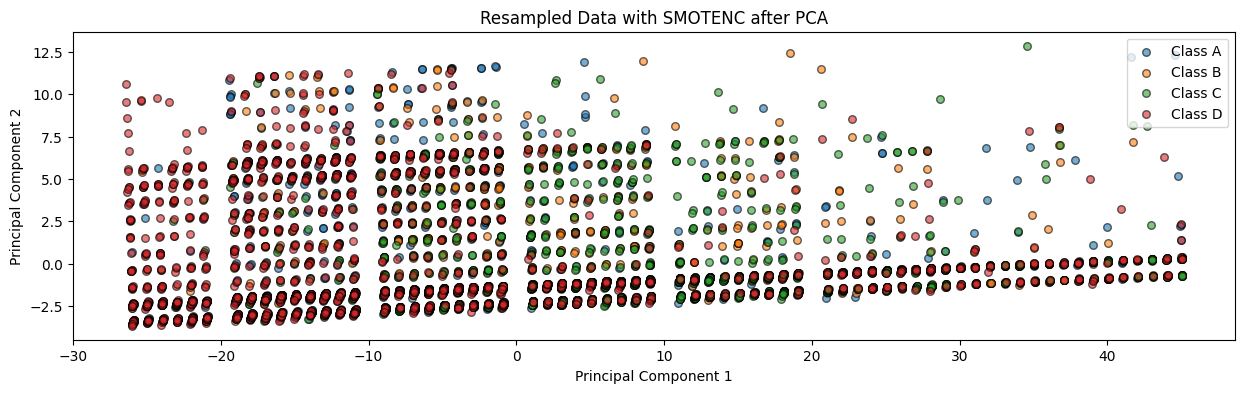

Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64


In [ ]:
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=0)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)
plot_data_with_pca(X_train_smotenc, y_train_smotenc, title="Resampled Data with SMOTENC after PCA")

In [ ]:
X_train.shape, X_train_smotenc.shape

((6454, 28), (7256, 28))

#### SMOTE-Tomek

In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

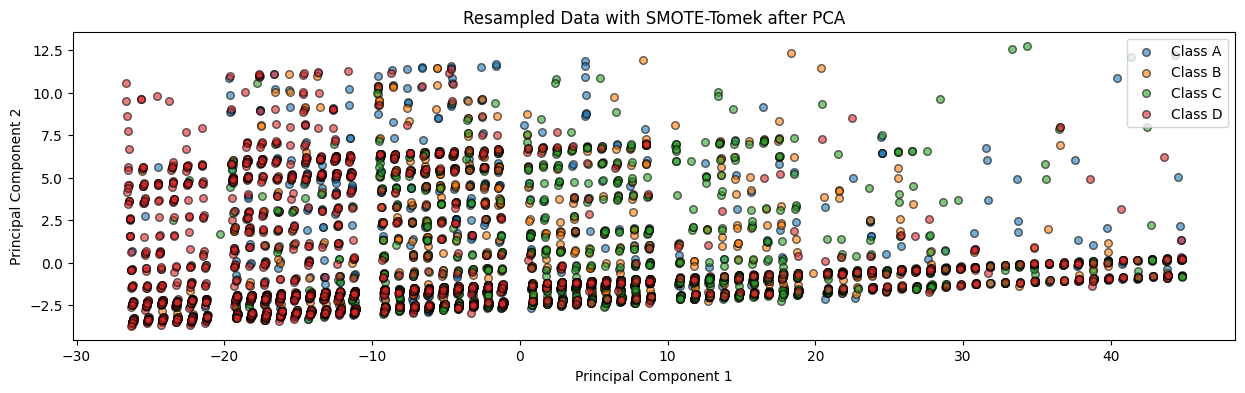

Segmentation
C    1641
B    1613
D    1588
A    1558
Name: count, dtype: int64


In [ ]:
plot_data_with_pca(X_train_smote_tomek, y_train_smote_tomek, title="Resampled Data with SMOTE-Tomek after PCA")

In [ ]:
X_train.shape, X_train_smote_tomek.shape

((6454, 28), (6400, 28))

Спостереження:

Як можемо побачити з візуалізацій в деяких їх частинах можемо бачити зміни щодо кількікості та яскравості точок. Але значних змін не відбувається.

Можемо зробити припущення, що ресамплінг не сильно вплине на якість моделювання.

## Завдання 3

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [ ]:
def train_model(X_train, y_train):
    model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    model.fit(X_train, y_train)
    return model

In [ ]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred)
    return report

In [ ]:
model_original = train_model(X_train, y_train)
model_smotenc = train_model(X_train_smotenc, y_train_smotenc)
model_smote_tomek = train_model(X_train_smote_tomek, y_train_smote_tomek)

In [ ]:
report_original = evaluate_model(model_original, X_val, y_val)
print("Original Dataset - Classification Report:\n", report_original)

Original Dataset - Classification Report:
               precision    recall  f1-score   support

           A       0.42      0.45      0.44       394
           B       0.40      0.17      0.24       372
           C       0.49      0.62      0.55       394
           D       0.65      0.75      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



In [ ]:
report_smotenc= evaluate_model(model_smotenc, X_val, y_val)
print("SMOTENK Dataset - Classification Report:\n", report_smotenc)

SMOTENK Dataset - Classification Report:
               precision    recall  f1-score   support

           A       0.42      0.48      0.45       394
           B       0.39      0.23      0.29       372
           C       0.50      0.58      0.54       394
           D       0.67      0.71      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [ ]:
report_smote_tomek = evaluate_model(model_smote_tomek, X_val, y_val)
print("SMOTE-Tomek Dataset - Classification Report:\n", report_smote_tomek)

SMOTE-Tomek Dataset - Classification Report:
               precision    recall  f1-score   support

           A       0.42      0.46      0.44       394
           B       0.37      0.24      0.30       372
           C       0.51      0.59      0.54       394
           D       0.68      0.71      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



**Спостереження**:

Для всих трьох моделей бачимо, що моделі мають схожі показники.
Precision та Recall для кожного класу залишаються майже незмінними.
F1-Score також подібний, з невеликим покращенням у SMOTENK та SMOTE-Tomek для класів C та D.
Accuracy залишається на рівні 51%, що показує, що застосування SMOTE або SMOTE-Tomek не призвело до суттєвого покращення, згідно до цієї метрики.

Як основну метрику я обираю F1-Score, адже ця метрика підходить для задач багатокласовоъ класифікації і об'єднує в собі precision і recall.

*Гіпотеза, чому якість моделей не сильно відрізняються:*

- Хоча в наборі присутній дисбаланс класів ми не можемо сказати, що один клас сильно домінує над іншим, тому застосування ресамплінгу не дає нам сильного покращення якості моделі.
До того ж в процесі проведення ресамплігу не було виявлено значних змін на візуалізаціях у порівнянні з оригінальним датасетом.

- Можливо логістична регресія не є найкращою моделлю для застосування, та варто подивистись в сторону інших моделей, та проекспериментувати з ними.

